In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

In [2]:
# Input and output k vector
# Assumes that input is log-spaced and output is linearly binned

kk  = np.logspace(-4.0,3.0,2000)
kout = np.arange(0,0.5,0.01)

In [4]:
# Load the window function:

win = np.loadtxt('eboss_window.txt')

rwin, w0, w2, w4, w6, w8 = win[:,0], win[:,1], win[:,2], win[:,3], win[:,4], win[:,5]
w0 /= w0[0]
w2 /= w0[0]
w4 /= w0[0]
w6 /= w0[0]
w8 /= w0[0]

In [5]:
# How to use the module:
from make_window_matrix import make_window_matrix

window_matrix = make_window_matrix((rwin,w0,w2,w4,w6,w8), kin = kk, kout=kout)

In [8]:
# Make fake data to test:
from loginterp import loginterp

ki, pi = np.loadtxt('fiducial_pk.txt', unpack=True)

b = 1
f = 1
p0in = (b**2 + 2./3 * b*f + 1./5*f**2 ) * loginterp(ki,pi)(kk)
p2in = (4./3 * b*f + 4./7*f**2 ) * loginterp(ki,pi)(kk)
p4in = 8./35*f**2  * loginterp(ki,pi)(kk)

pvector = np.concatenate((p0in, p2in, p4in))
pout    = np.dot(window_matrix.T, pvector)

In [12]:
# Compare matrix multiplication with direct transform of the example power spectrum:
from spherical_bessel_transform import SphericalBesselTransform

p0 = p0in
p2 = p2in
p4 = p4in
    
sbt   = SphericalBesselTransform(kk,fourier=True)
q0,xi0= sbt.sph(0,p0)
q2,xi2= sbt.sph(2,p2); xi2 = Spline(q2,xi2)(q0)
q4,xi4= sbt.sph(4,p4); xi4 = Spline(q4,xi4)(q0)

w0 = Spline(rwin,w0,ext=3)(q0)
w2 = Spline(rwin,w2,ext=1)(q0)
w4 = Spline(rwin,w4,ext=1)(q0)
w6 = Spline(rwin,w6,ext=1)(q0)
w8 = Spline(rwin,w8,ext=1)(q0)

    
sbt  = SphericalBesselTransform(q0,fourier=False)
    
xi0p   = xi0*w0 + 1./5.*xi2*w2  + 1./9.*xi4*w4
xi2p   = xi0*w2 + xi2*(w0+2./7.*w2+2./7.*w4) + \
                xi4*(2./7.*w2+100./693.*w4 + 25./143.*w6)
xi4p   = xi0*w4 + xi2*(18./35*w2 + 20./77*w4 + 45./143*w6)\
                 + xi4*(w0 + 20./77*w2 + 162./1001*w4 + 20./143*w6 + 490./2431*w8)
    
k0,p0   = sbt.sph(0,4*np.pi*xi0p)
k2,p2   = sbt.sph(2,4*np.pi*xi2p)
k4,p4   = sbt.sph(4,4*np.pi*xi4p)
    
thy0 = Spline(k0,p0,ext=1)
thy2 = Spline(k2,p2,ext=1)
thy4 = Spline(k4,p4,ext=1)
dx   = kout[1]-kout[0]
    
tmp0 = np.zeros_like(kout)
tmp2 = np.zeros_like(kout)
tmp4 = np.zeros_like(kout)

for i in range(kout.size):
    ss     = np.linspace(kout[i]-dx/2,kout[i]+dx/2,100)
    ivol   = 3.0/((kout[i]+dx/2)**3-(kout[i]-dx/2)**3)
        
    tmp0[i]= np.trapz(ss**2*thy0(ss),x=ss)*ivol
    tmp2[i]= np.trapz(ss**2*thy2(ss),x=ss)*ivol
    tmp4[i]= np.trapz(ss**2*thy4(ss),x=ss)*ivol
    
ptest = np.concatenate((tmp0,tmp2,tmp4))

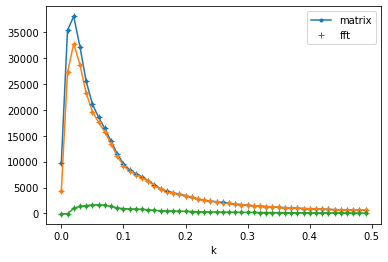

In [16]:
plt.plot(kout, pout[:50], 'C0.-',label='matrix')
plt.plot(kout, pout[50:100], 'C1.-')
plt.plot(kout, pout[100:], 'C2.-')

plt.plot(kout, ptest[:50], 'C0+',label='fft')
plt.plot(kout, ptest[50:100], 'C1+')
plt.plot(kout, ptest[100:150], 'C2+')

plt.xlabel('k')
plt.legend()

Text(0, 0.5, '$(P_{\\rm mat} - P_{\\rm fft}) / P_{\\rm fft}$')

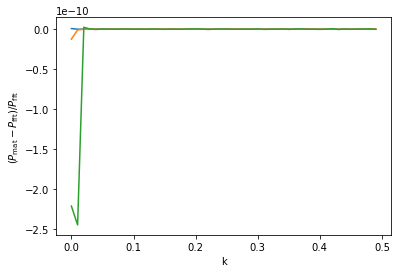

In [15]:
plt.plot(kout, pout[:50]/ptest[:50] - 1, 'C0')
plt.plot(kout, pout[50:100]/ptest[50:100] - 1, 'C1')
plt.plot(kout, pout[100:150]/ptest[100:150] - 1, 'C2')

plt.xlabel('k')
plt.ylabel(r'$(P_{\rm mat} - P_{\rm fft}) / P_{\rm fft}$')